# County-level Scatterplots

In [57]:
import numpy as np
import numpy.polynomial.polynomial as poly      # linear regression
import pandas as pd

import pickle

# opening external coordinates
import json

# opening urls
from urllib.request import urlopen

# benchmarking
from time import time

# date/time operations
from datetime import datetime, timedelta
from pytz import timezone

# plotting
import altair as alt
from altair import datum
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# for US map
from vega_datasets import data

# large datasets
alt.data_transformers.enable('data_server');

In [2]:
#hide
def optimize(df):
    '''
    Optimizes the data types in a pandas dataframe.
    '''
    dft = df.copy()
    # converts to datetime if possible
    dft = dft.apply(lambda col:
        pd.to_datetime(col, errors='ignore') if col.dtypes=='object' else col)
    
    # if there are less than half as many unique values as there are rows, convert to category
    for col in dft.select_dtypes(include='object'):
        if len(dft[col].unique()) / len(df[col]) < 0.5:
            dft[col] = dft[col].astype('category')
            
    # downcasts numeric columns if possible
    dft = dft.apply(lambda col: 
        pd.to_numeric(col, downcast='integer') if col.dtypes=='int64' else col)
    dft = dft.apply(lambda col: 
        pd.to_numeric(col, downcast='float') if col.dtypes=='float64' else col)
    
    return dft

In [3]:
#hide
df = optimize(pd.read_csv('../data/df.csv'))
la = timezone('US/Pacific')
last = df['date'].max()
df_slice = df[df['date'] == last]
df_slice.head()

,state,cluster,date,cases,deaths,county,total_pop,fips,white,black,...,delta_new_cases_7sg,delta_new_deaths_7sg,delta_new_cases_per_100k_7sg,delta_new_deaths_per_100k_7sg,delta_new_cases_15sg,delta_new_deaths_15sg,delta_new_cases_per_100k_15sg,delta_new_deaths_per_100k_15sg,days,mortality_rate
76382,Alabama,0,2020-08-11,25148,572,Autauga-Bibb-Chambers-Cherokee-Chilton-Clay-Cl...,1282042,01001-01007-01017-01019-01021-01027-01029-0103...,948951,242950,...,-59.642857,2.285714,-4.652176,0.178287,-3.950000,1.741667,-0.308102,0.135851,203,0.022745
76383,Alabama,4,2020-08-11,14409,249,Baldwin-Mobile,636444,01003-01097,419294,167703,...,-119.714287,3.857143,-18.809870,0.606046,-55.608334,1.258333,-8.737349,0.197713,203,0.017281
76384,Alabama,1,2020-08-11,13212,290,Barbour-Bullock-Butler-Choctaw-Clarke-Conecuh-...,419390,01005-01011-01013-01023-01025-01035-01041-0104...,186960,208094,...,-52.928570,1.500000,-12.620371,0.357662,-5.266667,0.975000,-1.255792,0.232481,203,0.021950
76385,Alabama,3,2020-08-11,20251,216,Blount-Calhoun-DeKalb-Etowah-Jackson-Limestone...,1019420,01009-01015-01049-01055-01071-01083-01095-0110...,800521,111621,...,-71.821426,3.571429,-7.045323,0.350339,-33.658333,1.191667,-3.301714,0.116897,203,0.010666
76386,Alabama,7,2020-08-11,4624,79,Coffee-Covington-Dale-Geneva-Henry-Houston,287921,01031-01039-01045-01061-01067-01069,204415,59030,...,-8.678572,3.071429,-3.014220,1.066761,2.666667,1.633333,0.926180,0.567285,203,0.017085


In [28]:
df_slice.columns

Index(['state', 'cluster', 'date', 'cases', 'deaths', 'county', 'total_pop',
       'fips', 'white', 'black', 'asian', 'hispanic', 'area_land', 'lon',
       'lat', 'votes_gop', 'votes_dem', 'total_votes', 'median_income',
       'pop25', 'no_hs', 'some_hs', 'hs', 'some_college', 'associates',
       'bachelors', 'graduate', 'never', 'rarely', 'sometimes', 'frequently',
       'always', 'pop_density', 'per_white', 'per_black', 'per_asian',
       'per_hispanic', 'per_total_votes', 'per_votes_gop', 'per_votes_dem',
       'education', 'mask', 'per_gop', 'cases_per_100k', 'deaths_per_100k',
       'new_cases', 'new_deaths', 'new_cases_per_100k', 'new_deaths_per_100k',
       'new_cases_7sg', 'new_deaths_7sg', 'new_cases_per_100k_7sg',
       'new_deaths_per_100k_7sg', 'new_cases_15sg', 'new_deaths_15sg',
       'new_cases_per_100k_15sg', 'new_deaths_per_100k_15sg',
       'delta_new_cases', 'delta_new_deaths', 'delta_new_cases_per_100k',
       'delta_new_deaths_per_100k', 'delta_new_cas

In [4]:
#hide
dem_df_ac = optimize(pd.read_csv('../data/processed/dem_df_ac.csv', 
                                 dtype={'fips':'str', 'cluster':'int'}))
print(dem_df_ac.shape)
dem_df_ac.head()

(518, 40)


,state,cluster,county,total_pop,fips,white,black,asian,hispanic,area_land,...,per_white,per_black,per_asian,per_hispanic,per_total_votes,per_votes_gop,per_votes_dem,education,mask,per_gop
0,Alabama,0,Autauga-Bibb-Chambers-Cherokee-Chilton-Clay-Cl...,1282042,01001-01007-01017-01019-01021-01027-01029-0103...,948951,242950,15387,48412,44122.914062,...,0.740187,0.189502,0.012002,0.037762,0.418653,0.711412,0.265271,2.862554,2.931403,0.728396
1,Alabama,1,Barbour-Bullock-Butler-Choctaw-Clarke-Conecuh-...,419390,01005-01011-01013-01023-01025-01035-01041-0104...,186960,208094,2891,11332,44918.742188,...,0.445790,0.496183,0.006893,0.027020,0.473404,0.465672,0.523106,2.615394,2.979478,0.470957
2,Alabama,2,Montgomery,226486,01101,74059,133283,7353,8344,2033.918457,...,0.326992,0.588482,0.032466,0.036841,0.417562,0.358753,0.620363,3.253709,3.029000,0.366405
3,Alabama,3,Blount-Calhoun-DeKalb-Etowah-Jackson-Limestone...,1019420,01009-01015-01049-01055-01071-01083-01095-0110...,800521,111621,11081,72491,17516.697266,...,0.785271,0.109495,0.010870,0.071110,0.416517,0.767825,0.204868,2.962179,2.972209,0.789381
4,Alabama,4,Baldwin-Mobile,636444,01003-01097,419294,167703,10840,22977,7301.599609,...,0.658807,0.263500,0.017032,0.036102,0.404556,0.636434,0.337265,3.096534,3.008253,0.653625


## Exploring the Correlations

In [5]:
#hide

def cov(x, y, w):
    return np.sum(w * (x - np.average(x, weights=w)) * (y - np.average(x, weights=w))) / np.sum(w)

def corr(x, y, w):
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))

y_cols = ['pop_density', 
          'per_white', 'per_black', 'per_asian', 'per_hispanic', 
          'per_total_votes', 'per_gop', 
          'median_income', 
          'education', 'mask']
x_cols = y_cols + ['cases_per_100k', 'deaths_per_100k', 
                   'new_cases_per_100k_15sg', 'new_deaths_per_100k_15sg', 
                   'delta_new_cases_per_100k_15sg', 'delta_new_deaths_per_100k_15sg']
w_col = 'total_pop'

Text(0.5, 0.98, 'covid correlation heatmap')

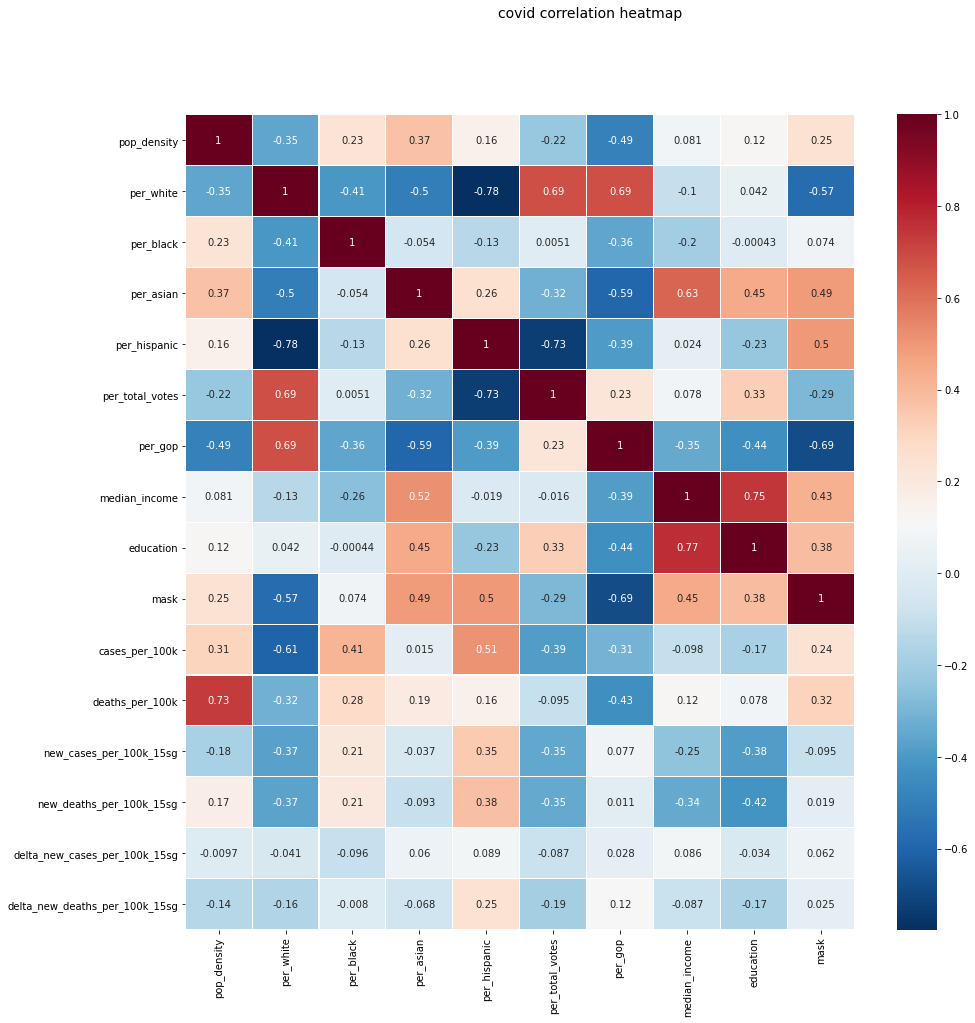

In [8]:
#hide_input
wcm = pd.DataFrame(index=x_cols, columns=y_cols)

for x in x_cols:
    for y in y_cols:
        wcm.loc[x, y] = corr(df_slice[x], df_slice[y], df_slice[w_col])
        
fig, (ax) = plt.subplots(1, 1, figsize=(15,15))

hm = sns.heatmap(np.array(wcm,dtype='float64'), 
                 ax=ax,
                 yticklabels=wcm.index,
                 xticklabels=wcm.columns,
                 cmap="RdBu_r",
                 annot=True, 
#                  fmt='.1f',
                 linewidths=.05)

# fig.subplots_adjust(top=0.93)
fig.suptitle('covid correlation heatmap', fontsize=14)

The following are, upon inspection, positively correlated with the total number of cases and deaths per cluster:
- population density (`pop_density`)
- percent black (`per_black`)
- percent hispanic (`per_hispanic`)
- mask discipline (`mask`)

The following are negatively correlated with the total number of cases and deaths per county:
- percent white (`per_white`)
- adjusted percent votes GOP in the 2016 general election (`per_gop`)

## new cases and deaths

The following features are positively correlated with the number of *new* cases and deaths per cluster:
- percent black
- percent hispanic

And the following are negatively correlated:
- percent white
- percent of population who voted in the general election 2016 (`per_total_votes`)
- median income (`median_income`)
- education coefficient (`education`)

# Scatter Plots (with color and size axes)

In each chart:

- size -- total cases

In [9]:
def make_bubble_chart(df, x_col, y_col, c_col, s_col='cases',
                      x_scale='linear', y_scale='linear', 
                      c_range=None, c_mid=None, line=True, split=False, clip=False):
    
    base_cols = ['cases', 'cases_per_100k', 'deaths', 'deaths_per_100k', 'mortality_rate']
    if s_col not in base_cols:
        s_col = 'cases'

    cols = ['date', 'state', 'county', 'total_pop'] + base_cols + [x_col, y_col, c_col]
    cols = list(set(cols))
    smax = np.max(df[s_col])
    smax = smax + (-smax) % 10

    if c_range==None:
        c_range = color_dict[c_col]['range']
    if c_mid==None:
        c_mid = color_dict[c_col]['mid']

    df = df[cols]
    
    base = alt.Chart(df).properties(
        title=f'{y_col} vs. {x_col} ({c_col}, cases)',
        width=720,
        height=480
    )
    
    circles = base.mark_circle(stroke='black', strokeWidth=0.25, opacity=0.8).encode(
        x=alt.X(
            f'{x_col}:Q',
            scale=alt.Scale(type=x_scale, zero=False)
        ),
        y=alt.Y(
            f'{y_col}:Q',
            scale=alt.Scale(type=y_scale, zero=False)
        ),
        size=alt.Size(
            f'{s_col}:Q',
            scale=alt.Scale(
                domain=[1,smax],
                range=[10,2000]
            ),
        ),
        color=alt.Color(
            f'{c_col}:Q',
            scale=alt.Scale(
                range=c_range,
                domain=[np.percentile(dem_df_ac[c_col], 1),
                        c_mid,
                        np.percentile(dem_df_ac[c_col], 99)],
                interpolate={
                    'type':'rgb', 
                    'gamma':0.75
                }
            ),
        ),
        tooltip=[
            'state:N', 'county:N', 'cases:Q', 'deaths:Q', 
            alt.Tooltip(
                'mortality_rate:Q',
                format='.3f'
            ),
            alt.Tooltip(
                f'{c_col}:Q',
                format='.2f',
            ),
            alt.Tooltip(
                f'{y_col}:Q',
                format='.2f',
            ),
            alt.Tooltip(
                f'{x_col}:Q',
                format='.2f',
            )
        ]
    )

    def make_line(split=False, side=None):
        if split:
            if side=='gt':
                df_ = df[df[c_col]>c_mid]
                color = c_range[-1]
            elif side=='lt':
                df_ = df[df[c_col]<=c_mid]
                color = c_range[0]
        else:
            df_ = df
            color = 'black'
        pfit = poly.polyfit(
            df_[x_col], 
            df_[y_col], 
            1, 
            w=df_['total_pop']
        )
        fit = poly.polyval(np.unique(df_[x_col]), pfit)
        line_df = pd.DataFrame({
            'x': np.unique(df_[x_col]),
            'y': fit
        })
        return alt.Chart(line_df).mark_line(
            color=color,
            strokeDash=[2,1],
            clip=True
        ).encode(
            x='x:Q',
            y=alt.Y(
                'y:Q', 
                scale=alt.Scale(domain=[
                    df_[y_col].min(),
                    df_[y_col].max()
                ])
            )
        )
    
    if line:
        if split:
            _line0 = make_line(True, 'lt')
            _line1 = make_line(True, 'gt')
            return circles + _line0 + _line1
        else:
            _line = make_line()
            return circles + _line
        
    else:
        return circles

In [26]:
#hide
#https://colorbrewer2.org/

color_dict = dict(
    # blue-red
    per_gop=dict(
        range=['#2166ac', '#92c5de', '#F7F7F7', '#f4a582', '#b2182b'],
        mid=0.5
    ),
    # pink-green
    mask=dict(
        range=['#c51b7d', '#f1b6da', '#F7F7F7', '#b8e186', '#4d9221'],
        mid=dem_df_ac['mask'].median()
    ),
    # purple-orange
    median_income=dict(
        range=['#542788', '#b2abd2', '#F7F7F7', '#fdb863', '#b35806'],
        mid=61937
    ),
    # green-purple
    education=dict(
        range=['#1b7837', '#a6dba0', '#F7F7F7', '#c2a5cf', '#762a83'],
        mid=dem_df_ac['education'].median()
    )
)

# COVID-19 Map

In [58]:
with open('../data/processed/geo_altair.p', 'rb') as f:
    geo_altair = pickle.load(f)

In [62]:
def make_map(df, c_col, s_col='cases', 
             c_range=None, c_mid=None):
    
    base_cols = ['cases', 'cases_per_100k', 'deaths', 'deaths_per_100k', 'mortality_rate']
#     if s_col not in base_cols:
#         s_col = 'cases'

    cols = ['date', 'state', 'county', 'total_pop', 'lat', 'lon', 'fips'] + base_cols + [c_col, s_col]
    cols = list(set(cols))
    smax = np.max(df[s_col])
    smax = smax + (-smax) % 10

    if c_range==None:
        c_range = color_dict[c_col]['range']
    if c_mid==None:
        c_mid = color_dict[c_col]['mid']

    df = df[cols]

    states = alt.topo_feature(data.us_10m.url, feature='states')
    

    background = alt.Chart(states).mark_geoshape(
        fill='#F2F2F2',
        stroke='white'
    ).properties(
        title='total cases',
        width=720,
        height=480
    ).project('albersUsa')
    
    counties = alt.Chart(geo_altair).mark_geoshape(
        stroke='white'
    ).encode(
        color=alt.Color(
            f'{c_col}:Q',
            scale=alt.Scale(
                range=c_range,
                domain=[np.percentile(df[c_col], 1),
                        c_mid,
                        np.percentile(df[c_col], 99)],
                interpolate={
                    'type':'rgb', 
                    'gamma':0.75
                }
            ),
        ),
        tooltip=[
            'state:N', 'county:N', 'cases:Q', 'deaths:Q', 
            alt.Tooltip(
                'mortality_rate:Q',
                format='.3f'
            ),
            alt.Tooltip(
                f'{s_col}:Q',
                format='.2f',
            ),
            alt.Tooltip(
                f'{c_col}:Q',
                format='.2f',
            )
        ]
    ).transform_lookup(
        lookup='id',
        from_=alt.LookupData(data=df[cols], key='fips', fields=cols)
    )
    
    return background + counties

In [64]:
make_map(df_slice, c_col='new_cases_per_100k_15sg',
         c_range=['#2c7bb6','#abd9e9','#ffffbf','#fdae61','#d7191c'],
         c_mid=0)

alt.LayerChart(...)

In [ ]:
def make_map(df, c_col, s_col='cases', 
             c_range=None, c_mid=None):
    
    base_cols = ['cases', 'cases_per_100k', 'deaths', 'deaths_per_100k', 'mortality_rate']
#     if s_col not in base_cols:
#         s_col = 'cases'

    cols = ['date', 'state', 'county', 'total_pop', 'lat', 'lon'] + base_cols + [c_col, s_col]
    cols = list(set(cols))
    smax = np.max(df[s_col])
    smax = smax + (-smax) % 10

    if c_range==None:
        c_range = color_dict[c_col]['range']
    if c_mid==None:
        c_mid = color_dict[c_col]['mid']

    df = df[cols]

    states = alt.topo_feature(data.us_10m.url, feature='states')
    

    background = alt.Chart(states).mark_geoshape(
        fill='#F2F2F2',
        stroke='white'
    ).properties(
        title='total cases',
        width=720,
        height=480
    ).project('albersUsa')
    
    counties = alt.Chart(geo_altair).mark_geoshape(
        stroke='white'
    ).encode(
        color=alt.Color(
            f'{c_col}:Q',
            scale=alt.Scale(
                range=c_range,
                domain=[np.percentile(df[c_col], 1),
                        c_mid,
                        np.percentile(df[c_col], 99)],
                interpolate={
                    'type':'rgb', 
                    'gamma':0.75
                }
            ),
        ),
    ).transform_lookup(
        lookup='id',
        from_=alt.LookupData(data=df[cols], key='fips', fields=cols)
    )

    counties = alt.Chart(df).mark_circle(
        stroke='black', strokeWidth=0.25, opacity=0.8
    ).encode(
        latitude='lat:Q',
        longitude='lon:Q',
        size=alt.Size(
            f'{s_col}:Q',
#             scale=alt.Scale(
#                 domain=[1,smax],
#                 range=[10,2000]
#             ),
        ),
        
        tooltip=[
            'state:N', 'county:N', 'cases:Q', 'deaths:Q', 
            alt.Tooltip(
                'mortality_rate:Q',
                format='.3f'
            ),
            alt.Tooltip(
                f'{s_col}:Q',
                format='.2f',
            ),
            alt.Tooltip(
                f'{c_col}:Q',
                format='.2f',
            )
        ]
    )
    
    return background + circles

In [55]:
make_map(df_slice, c_col='delta_new_cases_per_100k_15sg', s_col='new_cases_per_100k_15sg',
         c_range=['#2c7bb6','#abd9e9','#ffffbf','#fdae61','#d7191c'],
         c_mid=0)

alt.LayerChart(...)

## COVID-19 Density and Mortality Rate vs. Population Density

In [22]:
make_bubble_chart(df_slice, 'pop_density', 'cases_per_100k', 'per_gop',
                  x_scale='sqrt', y_scale='sqrt', split=False)

alt.LayerChart(...)

In [15]:
make_bubble_chart(df_slice, 'per_gop', 'cases_per_100k', 'per_gop',
                  x_scale='linear', y_scale='sqrt', split=False)

alt.LayerChart(...)

By far the largest predictor of total cases/deaths is population density. This does not appear to be an unfair characterization, given the fact that the disease spreads from person-to-person. Dense urban centers tend to lean Democratic, whereas sparse rural counties tend to lean Republican. Therefore, it makes sense that urban Democratic centers are being hit harder than their rural Republican counterparts.

The effects of urban density are further illustrated when discussing the mortality rate. In New York City, over 10% of those diagnosed have passed due to complications from the virus.

In [16]:
make_bubble_chart(df_slice, 'pop_density', 'mortality_rate', 'per_gop',
                  x_scale='sqrt', y_scale='sqrt', line=True, split=True)

alt.LayerChart(...)

In [17]:
make_bubble_chart(df_slice, 'per_gop', 'mortality_rate', 'per_gop',
                  x_scale='linear', y_scale='sqrt', line=True, split=False)

alt.LayerChart(...)

## COVID-19 Density vs. Mask Discipline

In [19]:
make_bubble_chart(df_slice, 'mask', 'cases_per_100k', 'per_gop',
                  x_scale='sqrt', y_scale='sqrt', line=True, split=False)

alt.LayerChart(...)

## COVID-19 Density vs. Educational Attainment

Educational attainment (`edu`) is defined as the weighted average of the highest degree of education for persons 25 and older within a given county:

- no HS -- 0
- some HS -- 1
- HS diploma or GED -- 2
- some college -- 3
- associate's degree -- 4
- bachelor's degree -- 5
- graduate or professional degree - 6

In [21]:
make_bubble_chart(df_slice, 'education', 'cases_per_100k', 'per_gop',
                  x_scale='sqrt', y_scale='sqrt', line=True, split=False)

alt.LayerChart(...)

In [30]:
#hide_input
params = dict(
    chart_title='Cases per 100k vs. Educational Attainment (% GOP)',
    x_col='education',
    x_scale='linear',
    y_col='cases_per_100k',
    y_scale='sqrt',
    s_col='cases',
    c_col='per_gop',
    w_col='total_pop'
)

case_edu = make_bubble_chart(df_slice, params)
case_edu

TypeError: make_bubble_chart() missing 2 required positional arguments: 'y_col' and 'c_col'

In [15]:
#hide_input
params = dict(
    chart_title='Mortality Rate vs. Educational Attainment (% GOP)',
    x_col='edu',
    x_scale='linear',
    y_col='new_cases_per_100k_15sg',
    y_scale='sqrt',
    s_col='cases',
    c_col='per_gop',
    w_col='total_pop'
)

new_case_edu = make_bubble_chart(df_slice, params)
new_case_edu

alt.LayerChart(...)

## COVID-19 Density vs. Mask Discipline

Mask discipline (`edu`) is defined as the weighted average of the answer to the following question: "How often do you wear a mask in public when you expect to be within six feet of another person?"

- never -- 0
- rarely -- 1
- sometimes -- 2
- frequently -- 3
- always -- 4

In [16]:
#hide_input
params = dict(
    chart_title='Cases per 100k vs. Mask Discipline (% GOP)',
    x_col='mask',
    x_scale='linear',
    y_col='cases_per_100k',
    y_scale='sqrt',
    s_col='cases',
    c_col='per_gop',
    w_col='total_pop'
)

mask_edu = make_bubble_chart(df_slice, params)
mask_edu

alt.LayerChart(...)

In [17]:
#hide_input
params = dict(
    chart_title='New Cases per 100k vs. Mask Discipline (% GOP)',
    x_col='mask',
    x_scale='linear',
    y_col='new_cases_per_100k_15sg',
    y_scale='sqrt',
    s_col='cases',
    c_col='per_gop',
    w_col='total_pop'
)

mask_edu = make_bubble_chart(df_slice, params)
mask_edu

alt.LayerChart(...)

In [18]:
#hide_input
params = dict(
    chart_title='Change in New Cases per 100k vs. Mask Discipline (% GOP)',
    x_col='mask',
    x_scale='linear',
    y_col='delta_new_cases_per_100k_15sg',
    y_scale='sqrt',
    s_col='cases',
    c_col='per_gop',
    w_col='total_pop'
)

mask_edu = make_bubble_chart(df_slice, params)
mask_edu

alt.LayerChart(...)

In [19]:
#hide_input
params = dict(
    chart_title='Case Density vs. Population Density (Mask Discipline)',
    x_col='pop_density',
    x_scale='sqrt',
    y_col='new_cases_per_100k_15sg',
    y_scale='sqrt',
    s_col='cases',
    c_col='mask',
    w_col='total_pop'
)

mask_edu = make_bubble_chart(df_slice, params)
mask_edu

alt.LayerChart(...)

# New Cases per 100k vs. Population Density, Education, and Mask Discipline

Mask use seems to increase with educational attainment and is somehow a partisan issue, with Republican counties having worse mask discipline. With the size of the circles representing new cases, we see that counties with a high education attainment and mask discipline ratines (top-right quadrant) seem to have a lower number of new cases than those with low education and mask discipline (bottom-left quadrant).

In [20]:
#hide_input
params = dict(
    chart_title='Case Density vs. Population Density, Education, and Mask Discipline',
    x_col='edu',
    x_scale='linear',
    y_col='mask',
    y_scale='linear',
    s_col='new_cases_per_100k_15sg',
    c_col='per_gop',
    w_col='total_pop'
)

medley = make_bubble_chart(df_slice, params)
medley

alt.LayerChart(...)

This is not particularly easy to read, so maybe we'll use matplotlib instead.

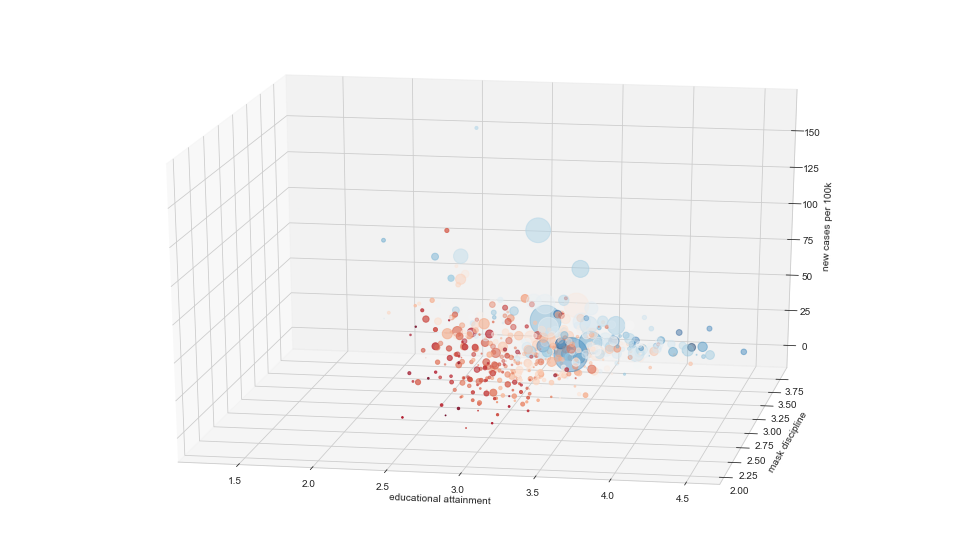

In [21]:
%matplotlib inline

sns.set_style('whitegrid')

fig = plt.figure(figsize=(17,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_slice['edu'], 
           df_slice['mask'], 
           df_slice['new_cases_per_100k_15sg'], 
           s=df_slice['cases'] / 200,
           c=df_slice['per_gop'],
           cmap='RdBu_r')
ax.set_xlabel('educational attainment')
ax.set_ylabel('mask discipline')
ax.set_zlabel('new cases per 100k')
ax.view_init(20,280)
plt.show()

## New Cases per 100k vs. Percent GOP

Recent COVID-19 cases, however, seem to be more prevalent in more GOP-weighted counties.

In [29]:
make_bubble_chart(df_slice, 'per_gop', 'new_cases_per_100k_15sg', 'per_gop',
                  x_scale='linear', y_scale='sqrt', line=True, split=False)

alt.LayerChart(...)

This is most likely skewed by the fact that New York City -- a prior epicenter of COVID-19 cases and the largest group in this dataset -- has relatively few cases now.

In [30]:
make_bubble_chart(df_slice, 'per_gop', 'new_cases_per_100k_15sg', 'per_gop',
                  x_scale='linear', y_scale='sqrt', line=True, split=True)

alt.LayerChart(...)

In [31]:
make_bubble_chart(df_slice, 'per_gop', 'delta_new_cases_per_100k_15sg', 'per_gop',
                  x_scale='linear', y_scale='sqrt', line=True, split=False)

alt.LayerChart(...)

In [32]:
make_bubble_chart(df_slice, 'per_gop', 'delta_new_cases_per_100k_15sg', 'per_gop',
                  x_scale='linear', y_scale='sqrt', line=True, split=True)

alt.LayerChart(...)

## Change in New Cases per 100k vs. Percent GOP

Changes in cases do not seem to be predicted by political affiliation.

In [24]:
#hide_input
params = dict(
    chart_title='Change in New Cases vs. Percent GOP',
    x_col='per_gop',
    x_scale='linear',
    y_col='delta_new_cases_per_100k_15sg',
    y_scale='linear',
    s_col='cases',
    c_col='per_gop',
    w_col='total_pop'
)

del_case_gop = make_bubble_chart(df_slice, params)
del_case_gop

alt.LayerChart(...)

In [25]:
#hide_input
params = dict(
    chart_title='Change in New Cases vs. Percent GOP',
    x_col='per_gop',
    x_scale='linear',
    y_col='delta_new_cases_per_100k_15sg',
    y_scale='linear',
    s_col='cases',
    c_col='per_gop',
    w_col='total_pop'
)

del_case_gop_split = make_bubble_chart(df_slice, params, split=True)
del_case_gop_split

alt.LayerChart(...)

## Case Rate Charts

Counties in the upper right portion of this chart face the highest risk of a worsening pandemic.

In [33]:
make_bubble_chart(df_slice, 'new_cases_per_100k_15sg', 'delta_new_cases_per_100k_15sg', 'per_gop',
                  x_scale='sqrt', y_scale='sqrt', line=True, split=True)

alt.LayerChart(...)